# Spray Glider - Rossby Deformation Radius Scale Analysis  

**Purpose**: Code for computing the Rossby Deformation Radius from Spray Glider data 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Supress decrepation warnings

In [2]:
import warnings

# Suppress specific category of warnings (e.g., deprecation warnings)
warnings.filterwarnings("ignore")


Import python libraries


In [3]:
#--- Build-in Python Functions ---# 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import sys
import os
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy import stats
import gsw

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
import cartopy_figs as cart
from autocorr import compute_glider_autocorr,compute_decor_scale
from spectra import spectra_autocov

Set data analysis parameters

In [4]:
# Set time and space parameters
years_d      = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']    # Specifies the year(s) to analyze
season       = 'all'                         # Specifies the season to analyze for the Rossby deformation radius
on_lim       = -1000                         # Specifies the depth limit for the onshelf region 
off_lim      = -3150                         # Specifies the depth limit for the offshelf region 

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

# Set plotting parameters 
fontsize = 14

Load spray glider intermediate data products

In [5]:
#--- Spray Glider Data ---# 
filename_sg = PATH + "/data/spray_gliders/CUGN_line_80.nc"
nc = Dataset(filename_sg, 'r')

# Extract data variables
profile = nc.variables['profile'][:]
depth   = nc.variables['depth'][:]

lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

temperature = nc.variables['temperature'][:]
salinity = nc.variables['salinity'][:]
doxy = nc.variables['doxy'][:]
chla = nc.variables['chlorophyll_a'][:]

#--- Intermediate Data ---# 
filename_int = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data.nc"
nc = Dataset(filename_int, 'r')

# Extract data variables
dist           = nc.variables['DIST'][:]
water_depth    = nc.variables['WATER_DEPTH'][:]
Pressure       = nc.variables['Pressure'][:]
SA             = nc.variables['ASal'][:]
CT             = nc.variables['CTemp'][:]
sigma0         = nc.variables['SIG'][:]
Nsquared       = nc.variables['N2_ndgm'][:]
Time           = nc.variables['TIME'][:]
depth_mid      = nc.variables['depth_mid'][:]

Compute the average in-situ temperature, absolute salinity, pressure, and potential density profile on-shelf and off-shelf

In [6]:
# Set the upper and lower depth limits for the shelf-break region 
upper_lim = on_lim + 100
lower_lim = off_lim - 300

# Find the on-shelf and off-shelf profiles
idx_depth_on  = water_depth >= on_lim
idx_depth_trans = (water_depth >= lower_lim) & (water_depth <= upper_lim)
idx_depth_off = water_depth <= off_lim

# Find summer/winter months profiles
months = np.ma.array([m.month if not np.ma.is_masked(m) else np.ma.masked for m in time], 
                    mask=[np.ma.is_masked(m) for m in time])
if season == 'summer':  
    idx_time = (months == 7) | (months == 8) | (months == 9)
elif season == 'winter': 
    idx_time = (months == 1) | (months == 2) | (months == 3)
elif season == 'all':
    idx_time = np.ones(len(time))

# Combine boolean arrays
idx_on = np.logical_and(idx_depth_on, idx_time)
idx_trans = np.logical_and(idx_depth_trans, idx_time)
idx_off = np.logical_and(idx_depth_off, idx_time)

# Compute the bouyancy frequency 
Nz = np.sqrt(Nsquared)

# Compute mean and standard error of the mean (assuming each profile is an independent observation) profiles 

#--- On-shelf ---# 
meanH_on    = np.ma.mean(water_depth[idx_on])
meanLat_on    = np.ma.mean(lat[idx_on])
meanTemp_on   = np.ma.mean(temperature[:,idx_on],axis=1)
meanCT_on     = np.ma.mean(CT[:,idx_on],axis=1)
meanSA_on     = np.ma.mean(SA[:,idx_on],axis=1)
meanPres_on   = np.ma.mean(Pressure[:,idx_on],axis=1)
meanSigma0_on = np.ma.mean(sigma0[:,idx_on],axis=1)
meanNsquared_on = np.ma.mean(Nsquared[:,idx_on],axis=1)
meanNz_on = np.ma.mean(Nz[:,idx_on],axis=1)
stdmTemp_on   = np.ma.std(temperature[:,idx_on],axis=1,ddof=1)/np.sqrt(np.ma.count(temperature[:,idx_on], axis=1))
stdmCT_on   = np.ma.std(CT[:,idx_on],axis=1,ddof=1)/np.sqrt(np.ma.count(CT[:,idx_on], axis=1))
stdmSA_on     = np.ma.std(SA[:,idx_on],axis=1,ddof=1)/np.sqrt(np.ma.count(SA[:,idx_on], axis=1))
stdmPres_on   = np.ma.std(Pressure[:,idx_on],axis=1,ddof=1)/np.sqrt(np.ma.count(Pressure[:,idx_on], axis=1))
stdmSigma0_on = np.ma.std(sigma0[:,idx_on],axis=1,ddof=1)/np.sqrt(np.ma.count(sigma0[:,idx_on], axis=1))
stdmNsquared_on = np.ma.std(Nsquared[:,idx_on],axis=1,ddof=1)/np.sqrt(np.ma.count(Nsquared[:,idx_on], axis=1))
stdmNz_on = np.ma.std(Nz[:,idx_on],axis=1,ddof=1)/np.sqrt(np.ma.count(Nz[:,idx_on], axis=1))

#--- Shelf Break ---# 
meanH_trans    = np.ma.mean(water_depth[idx_trans])
meanLat_trans    = np.ma.mean(lat[idx_trans])
meanTemp_trans   = np.ma.mean(temperature[:,idx_trans],axis=1)
meanCT_trans     = np.ma.mean(CT[:,idx_trans],axis=1)
meanSA_trans     = np.ma.mean(SA[:,idx_trans],axis=1)
meanPres_trans   = np.ma.mean(Pressure[:,idx_trans],axis=1)
meanSigma0_trans = np.ma.mean(sigma0[:,idx_trans],axis=1)
meanNsquared_trans = np.ma.mean(Nsquared[:,idx_trans],axis=1)
meanNz_trans     = np.ma.mean(Nz[:,idx_trans],axis=1)
stdmTemp_trans   = np.ma.std(temperature[:,idx_trans],axis=1,ddof=1)/np.sqrt(np.ma.count(temperature[:,idx_trans], axis=1))
stdmCT_trans     = np.ma.std(CT[:,idx_trans],axis=1,ddof=1)/np.sqrt(np.ma.count(CT[:,idx_trans], axis=1))
stdmSA_trans     = np.ma.std(SA[:,idx_trans],axis=1,ddof=1)/np.sqrt(np.ma.count(SA[:,idx_trans], axis=1))
stdmPres_trans   = np.ma.std(Pressure[:,idx_trans],axis=1,ddof=1)/np.sqrt(np.ma.count(Pressure[:,idx_trans], axis=1))
stdmSigma0_trans = np.ma.std(sigma0[:,idx_trans],axis=1,ddof=1)/np.sqrt(np.ma.count(sigma0[:,idx_trans], axis=1))
stdmNsquared_trans = np.ma.std(Nsquared[:,idx_trans],axis=1,ddof=1)/np.sqrt(np.ma.count(Nsquared[:,idx_trans], axis=1))
stdmNz_trans = np.ma.std(Nz[:,idx_trans],axis=1,ddof=1)/np.sqrt(np.ma.count(Nz[:,idx_trans], axis=1))

#--- Off-shelf ---# 
meanH_off    = np.ma.mean(water_depth[idx_off])
meanLat_off    = np.ma.mean(lat[idx_off])
meanTemp_off   = np.ma.mean(temperature[:,idx_off],axis=1)
meanCT_off   = np.ma.mean(CT[:,idx_off],axis=1)
meanSA_off     = np.ma.mean(SA[:,idx_off],axis=1)
meanPres_off   = np.ma.mean(Pressure[:,idx_off],axis=1)
meanSigma0_off = np.ma.mean(sigma0[:,idx_off],axis=1)
meanNsquared_off = np.ma.mean(Nsquared[:,idx_off],axis=1)
meanNz_off     = np.ma.mean(Nz[:,idx_off],axis=1)
stdmTemp_off   = np.ma.std(temperature[:,idx_off],axis=1,ddof=1)/np.sqrt(np.ma.count(temperature[:,idx_off], axis=1))
stdmCT_off     = np.ma.std(temperature[:,idx_off],axis=1,ddof=1)/np.sqrt(np.ma.count(CT[:,idx_off], axis=1))
stdmSA_off     = np.ma.std(SA[:,idx_off],axis=1,ddof=1)/np.sqrt(np.ma.count(SA[:,idx_off], axis=1))
stdmPres_off   = np.ma.std(Pressure[:,idx_off],axis=1,ddof=1)/np.sqrt(np.ma.count(Pressure[:,idx_off], axis=1))
stdmSigma0_off = np.ma.std(sigma0[:,idx_off],axis=1,ddof=1)/np.sqrt(np.ma.count(sigma0[:,idx_off], axis=1))
stdmNsquared_off = np.ma.std(Nsquared[:,idx_off],axis=1,ddof=1)/np.sqrt(np.ma.count(Nsquared[:,idx_off], axis=1))
stdmNz_off = np.ma.std(Nz[:,idx_off],axis=1,ddof=1)/np.sqrt(np.ma.count(Nz[:,idx_off], axis=1))

# Convert bouyancy frequency to cycles per hour
meanNz_on_hr = meanNz_on*(60)*(60)
meanNz_trans_hr = meanNz_trans*(60)*(60)
meanNz_off_hr = meanNz_off*(60)*(60)
stdmNz_on_hr = stdmNz_on*(60)*(60)
stdmNz_trans_hr = stdmNz_trans*(60)*(60)
stdmNz_off_hr = stdmNz_off*(60)*(60)

Plot the average profiles

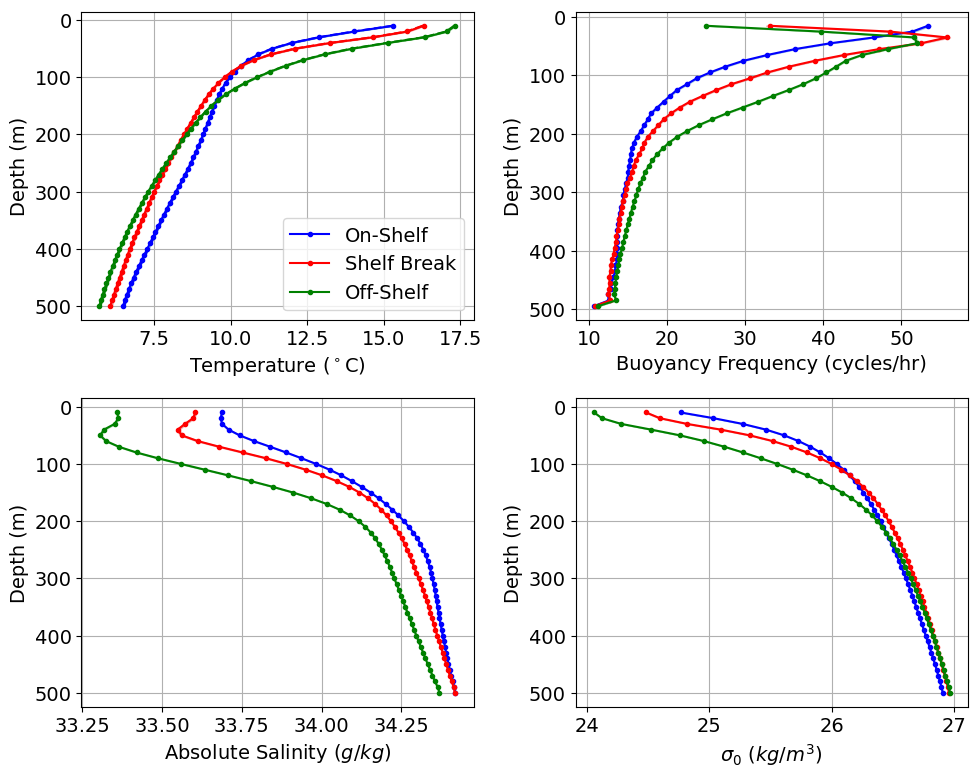

In [7]:
# Set plotting parameters
fontsize = 14
plt.rcParams.update({'font.size': fontsize}) 
plt.rcParams['text.usetex'] = False

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

#--- Suplot #1 ---# 

# Plot in-situ and Conservative temperature in on/off-shelf regions
axes[0,0].plot(meanTemp_on,depth,'b--')
axes[0,0].plot(meanCT_on,depth,'b.-', label="On-Shelf")
axes[0,0].plot(meanTemp_trans,depth,'r--')
axes[0,0].plot(meanCT_trans,depth,'r.-', label="Shelf Break")
axes[0,0].plot(meanTemp_off,depth,'g--')
axes[0,0].plot(meanCT_off,depth,'g.-', label="Off-Shelf")

# Plot standard error of the mean 
axes[0,0].fill_betweenx(depth,meanTemp_on - stdmTemp_on,meanTemp_on + stdmTemp_on,color="tab:blue",alpha=0.3)
axes[0,0].fill_betweenx(depth, meanCT_on - stdmCT_on,meanCT_on + stdmCT_on,color="tab:blue",alpha=0.3)
axes[0,0].fill_betweenx(depth,meanTemp_trans - stdmTemp_trans,meanTemp_trans + stdmTemp_trans,color="tab:red",alpha=0.3)
axes[0,0].fill_betweenx(depth, meanCT_trans - stdmCT_trans,meanCT_trans + stdmCT_trans,color="tab:red",alpha=0.3)
axes[0,0].fill_betweenx(depth, meanTemp_off - stdmTemp_off,meanTemp_off + stdmTemp_off,color="tab:green",alpha=0.3)
axes[0,0].fill_betweenx(depth, meanCT_off - stdmCT_off,meanCT_off + stdmCT_off,color="tab:green",alpha=0.3)

# Set axis attributes
axes[0,0].set_xlabel(r"Temperature ($^\circ$C)")
axes[0,0].set_ylabel(r"Depth (m)")
axes[0,0].grid()
axes[0,0].legend(loc='lower right')

# Reverse the direction of the y-axis 
axes[0,0].invert_yaxis()

#--- Suplot #2 ---# 

# Plot Absolute salinity in on/off-shelf regions
axes[1,0].plot(meanSA_on,depth,'b.-')
axes[1,0].plot(meanSA_trans,depth,'r.-')
axes[1,0].plot(meanSA_off,depth,'g.-')

# Plot standard error of the mean 
axes[1,0].fill_betweenx(depth,meanSA_on - stdmSA_on,meanSA_on + stdmSA_on,color="tab:blue",alpha=0.3)
axes[1,0].fill_betweenx(depth,meanSA_trans - stdmSA_trans,meanSA_trans + stdmSA_trans,color="tab:red",alpha=0.3)
axes[1,0].fill_betweenx(depth,meanSA_off - stdmSA_off,meanSA_off + stdmSA_off,color="tab:green",alpha=0.3)

# Set axis attributes
axes[1,0].set_xlabel(r"Absolute Salinity ($g/kg$)")
axes[1,0].set_ylabel(r"Depth (m)")
axes[1,0].grid()

# Reverse the direction of the y-axis 
axes[1,0].invert_yaxis()

#--- Suplot #3 ---# 

# Plot buoyancy frequency in on/off-shelf regions
axes[0,1].plot(meanNz_on_hr,depth_mid,'b.-')
axes[0,1].plot(meanNz_trans_hr,depth_mid,'r.-')
axes[0,1].plot(meanNz_off_hr,depth_mid,'g.-')

# Plot standard error of the mean 
axes[0,1].fill_betweenx(depth_mid,meanNz_on_hr - stdmNz_on_hr,meanNz_on_hr + stdmNz_on_hr,color="tab:blue",alpha=0.3)
axes[0,1].fill_betweenx(depth_mid,meanNz_trans_hr - stdmNz_trans_hr,meanNz_trans_hr + stdmNz_trans_hr,color="tab:red",alpha=0.3)
axes[0,1].fill_betweenx(depth_mid,meanNz_off_hr - stdmNz_off_hr,meanNz_off_hr + stdmNz_off_hr,color="tab:green",alpha=0.3)

# Set axis attributes
axes[0,1].set_xlabel(r"Buoyancy Frequency (cycles/hr)")
axes[0,1].set_ylabel(r"Depth (m)")
axes[0,1].grid()

# Reverse the direction of the y-axis 
axes[0,1].invert_yaxis()

#--- Suplot #4 ---# 

# Plot Density in on/off-shelf regions
axes[1,1].plot(meanSigma0_on,depth,'b.-')
axes[1,1].plot(meanSigma0_trans,depth,'r.-')
axes[1,1].plot(meanSigma0_off,depth,'g.-')

# Plot standard error of the mean 
axes[1,1].fill_betweenx(depth,meanSigma0_on - stdmSigma0_on,meanSigma0_on + stdmSigma0_on,color="tab:blue",alpha=0.3)
axes[1,1].fill_betweenx(depth,meanSigma0_trans - stdmSigma0_trans,meanSigma0_trans + stdmSigma0_trans,color="tab:red",alpha=0.3)
axes[1,1].fill_betweenx(depth,meanSigma0_off - stdmSigma0_off,meanSigma0_off + stdmSigma0_off,color="tab:green",alpha=0.3)

# Set axis attributes
axes[1,1].set_xlabel(r"$\sigma_0$ ($kg/m^3$)")
axes[1,1].set_ylabel(r"Depth (m)")
axes[1,1].grid()

# Reverse the direction of the y-axis 
axes[1,1].invert_yaxis()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/mean_profiles_'  + years_d[0] + '_to_' + years_d[-1] + '_' + season, bbox_inches = 'tight', dpi=300)

Compute the baroclinic Rossby radius of deformation for the first 20 modes using the Chelton et al. (1998)

$$
\lambda_m = \frac{c_m}{\lvert f(\theta) \rvert}
$$

where $f(\theta) = 2\Omega \sin\theta$ is the Coriolis parameter for earth rotation rate $\Omega$ and latitude $\theta$, and $c_m$ is the phase speed of the long mode-m gravity waves in a nonrotating, continuously stratified fluid (Gill 1982). The approximate solution for $c_m$ can be obtained by the WKB method: 

$$
c_m \approx c_m^{WKB} = \frac{1}{m\pi} \int^0_{-H} N(z)dz, \;\; m\geq 1
$$

In [8]:
# Set physical parameters
omega = (2*np.pi)/86400           # Earth's rotation rate, Units: rad/sec
modes = np.arange(1,20+1,1)       # Discrete modes of the long gravity waves

# Compute the coriolis parameter on and off shelf 
f_on = 2*omega*np.sin(np.radians(meanLat_on))
f_trans = 2*omega*np.sin(np.radians(meanLat_trans))
f_off = 2*omega*np.sin(np.radians(meanLat_off))

# Initalize arrays
c_m_on = np.zeros(20)
c_m_trans = np.zeros(20)
c_m_off = np.zeros(20)
Ro_m_on = np.zeros(20)
Ro_m_trans = np.zeros(20)
Ro_m_off = np.zeros(20)

# Loop through the first 20 modes 
for m in range(1,20+1): 

    # Compute the phase speed of the long mode-m gravity waves 
    c_m_on[m-1] = (1/(m*np.pi)) * np.trapz(meanNz_on,depth_mid)
    c_m_trans[m-1] = (1/(m*np.pi)) * np.trapz(meanNz_trans,depth_mid)
    c_m_off[m-1] = (1/(m*np.pi)) * np.trapz(meanNz_off,depth_mid)

    # Compute the Baroclinic rossby radius of deformation for the mth mode in units of kilometers
    Ro_m_on[m-1] = c_m_on[m-1]/abs(f_on) * (1/1000)
    Ro_m_trans[m-1] = c_m_trans[m-1]/abs(f_trans) * (1/1000)
    Ro_m_off[m-1] = c_m_off[m-1]/abs(f_off) * (1/1000)

Plot the Rossby radius of deformation for each mode

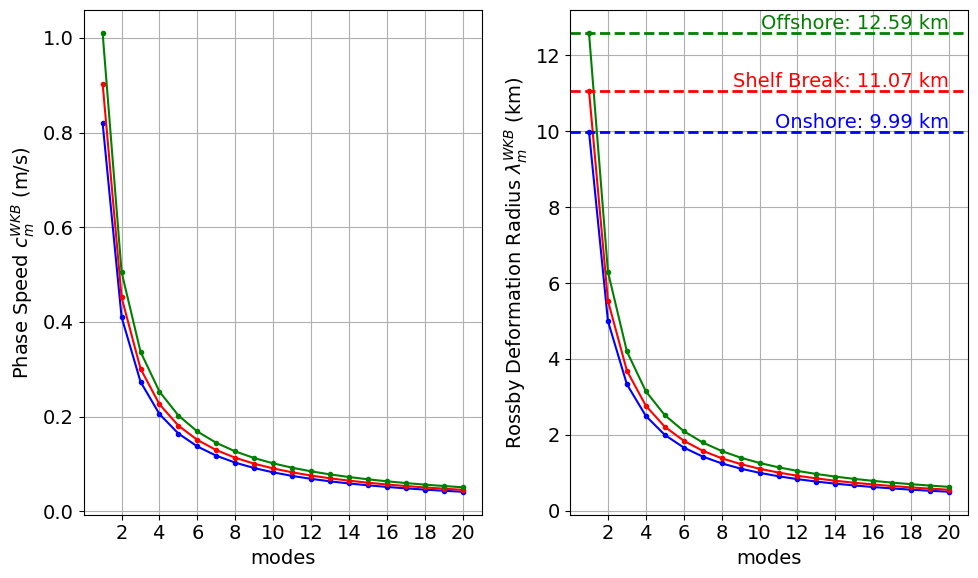

In [9]:
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

#--- Suplot #1 ---# 

# Plot phase speeds in on/off-shelf regions
axes[0].plot(modes,c_m_on,'b.-')
axes[0].plot(modes,c_m_trans,'r.-')
axes[0].plot(modes,c_m_off,'g.-')

# Set axis attributes
axes[0].set_xlabel(r"modes")
axes[0].set_ylabel(r"Phase Speed $c_m^{WKB}$ (m/s)")
axes[0].set_xlim(0,21)
#axes[0].set_ylim(0,1.2)
axes[0].set_xticks(np.arange(2,21,2))
axes[0].grid()
#axes[0].legend()

#--- Suplot #2 ---# 

# Plot baroclinic rossby radius of deformation in on/off-shelf regions
axes[1].plot(modes,Ro_m_on,'b.-')
axes[1].plot(modes,Ro_m_trans,'r.-')
axes[1].plot(modes,Ro_m_off,'g.-')

# Plot on and off-shelf limits
plt.axhline(Ro_m_on[0], color='b', linestyle='--', linewidth=2)
plt.axhline(Ro_m_trans[0], color='r', linestyle='--', linewidth=2)
plt.axhline(Ro_m_off[0], color='g', linestyle='--', linewidth=2)

# Add label text near the vertical lines
plt.text(modes[-1],Ro_m_on[0], r'Onshore: ' + str(np.round(Ro_m_on[0],2)) + ' km', color='b', fontsize=fontsize, ha='right',va='bottom',rotation=0) 
plt.text(modes[-1],Ro_m_trans[0], r'Shelf Break: ' + str(np.round(Ro_m_trans[0],2)) + ' km', color='r', fontsize=fontsize, ha='right',va='bottom',rotation=0) 
plt.text(modes[-1],Ro_m_off[0], r'Offshore: ' + str(np.round(Ro_m_off[0],2)) + ' km', color='g', fontsize=fontsize, ha='right',va='bottom',rotation=0)

# Set axis attributes
axes[1].set_xlabel(r"modes")
axes[1].set_ylabel(r"Rossby Deformation Radius $\lambda_m^{WKB}$ (km)")
axes[1].set_xlim(0,21)
#axes[1].set_ylim(-0,14)
axes[1].set_xticks(np.arange(2,21,2))
axes[1].grid()
#axes[1].legend()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/phase_speed_deformation_radius_'  + years_d[0] + '_to_' + years_d[-1] + '_' + season + '_extrapolate', bbox_inches = 'tight', dpi=300)

Compute the barotropic Rossby radius of deformation for completeness

In [10]:
# Set the physical parameters
g     = 9.81                      # Gravitational acceleration, Units: m/s^2
omega = (2*np.pi)/86400           # Earth's rotation rate, Units: rad/sec
phi_on = np.radians(np.ma.mean(meanLat_on))    # Average Latitude, Units: rad
phi_trans = np.radians(np.ma.mean(meanLat_trans)) # Average Latitude, Units: rad
phi_off = np.radians(np.ma.mean(meanLat_off))  # Average Latitude, Units: rad

# Compute the coriolis parameter 
f_on    = 2*omega*np.sin(phi_on)
f_trans = 2*omega*np.sin(phi_trans)
f_off   = 2*omega*np.sin(phi_off)

# Compute the barotropic rossby radius of deformation in units of kilometers
c_on      = np.sqrt(g*abs(meanH_on))    # Units: m/s
c_trans   = np.sqrt(g*abs(meanH_trans))    # Units: m/s
c_off     = np.sqrt(g*abs(meanH_off))   # Units: m/s
Ro_on     = c_on/f_on * (1/1000)  # Units: km
Ro_trans  = c_on/f_trans * (1/1000)  # Units: km
Ro_off    = c_off/f_off * (1/1000) # Units: km

# Print results 
print('On-shelf: ' + str(np.round(Ro_on,2)) + ' km')
print('Shelf-Break: ' + str(np.round(Ro_trans,2)) + ' km')
print('Off-shelf: '+ str(np.round(Ro_off,2)) + ' km')

On-shelf: 809.74 km
Shelf-Break: 814.36 km
Off-shelf: 2458.36 km


### Development Code from iterations on the Rossby deformation radius code

Compute the bouyancy frequency from the ***mean temperature, salinity, and pressure profiles*** using two formulations: 

1. Emery et al. (1984) formulation: Potential Density Method

$$
N^2(z_{k +1/2}) = - \frac{g}{\rho_o} \bigg[\frac{\rho_{\theta}(z_k) - \rho_{\theta}(z_{k + 1})}{ z_k - z_{k+1}} \bigg]
$$

where $z_{k+1/2} \equiv (z_k + z_{k + 1})/2$ is the midpoint between standard depths $z_k$ and $z_{k+1}$ with positive upward convention for depth $z_k > z_{k+1}$, $g = 9.81 m/s^{2}$ is the gravitational accerelation constant, $\rho_{o}$ is the average potential density in the top 100 meters throughout the time record, and $\rho_\theta$ is potential density.

2. Chelton et al. (1998) formulation: Neutral density gradient method 

$$
N^2(z_{k +1/2}) = - \frac{g}{\rho_o} \bigg[\frac{\rho(z_k \rightarrow z_{k+1/2}) - \rho(z_{k+1} \rightarrow z_{k+1/2})}{z_k - z_{k+1}} \bigg]
$$

Note that the potential density method has a systematically low bias due to the thermobaric effect: the increase in compressiblity of sea water with decreasing temperature. The neutral density gradient method is more robust and accurate. 

In [11]:
# Set physical constants 
g = 9.81                 
rho_theta_on = meanSigma0_on + 1000
rho_theta_off = meanSigma0_off + 1000
rho0_on = np.ma.mean(rho_theta_on[(depth >= depth[0]) & (depth <= 500)])
rho0_off = np.ma.mean(rho_theta_off[(depth >= depth[0]) & (depth <= 500)])
depth_conv = -1*depth
N_depth = len(depth)

#--- Potential Density Method ---# 

# Compute N^2(z) profile 
Nsquare_pdm_on = (-g/rho0_on) * (np.diff(rho_theta_on) / np.diff(depth_conv)) 
Nsquare_pdm_off = (-g/rho0_off) * (np.diff(rho_theta_off) / np.diff(depth_conv)) 

# Compute the midpoints of the depth bins 
depth_mid_pdm = (depth[:-1] + depth[1:]) / 2

# Compute bouyancy frequency in units of cycles/sec
Nz_pdm_on = np.sqrt(Nsquare_pdm_on) 
Nz_pdm_off = np.sqrt(Nsquare_pdm_off) 

#--- Neutral Density Gradient Method ---# 

# Initalize arrays 
depth_mid_ndgm = np.zeros((N_depth-1))
Nsquare_ndgm_on = np.zeros((N_depth-1))
Nsquare_ndgm_off = np.zeros((N_depth-1))

# Loop through depth pairs 
for k in range(0,len(depth_conv)-1):

    # Compute the midpoint standard depth 
    z_half = (depth_conv[k] + depth_conv[k+1]) / 2

    # Convert standard depth to a reference pressure 
    p_half_on = gsw.conversions.z_from_p(z_half,meanLat_on)
    p_half_off = gsw.conversions.z_from_p(z_half,meanLat_off)

    # Compute the potential density referenced to p_half pressure
    sigma_ref_on_top  = gsw.pot_rho_t_exact(meanSA_on[k], meanTemp_on[k], meanPres_on[k], p_half_on)
    sigma_ref_on_bottom  = gsw.pot_rho_t_exact(meanSA_on[k+1], meanTemp_on[k+1], meanPres_on[k+1], p_half_on)
    sigma_ref_off_top  = gsw.pot_rho_t_exact(meanSA_off[k], meanTemp_off[k], meanPres_off[k], p_half_off)
    sigma_ref_off_bottom  = gsw.pot_rho_t_exact(meanSA_off[k+1], meanTemp_off[k+1], meanPres_off[k+1], p_half_off)

    # Compute N^2(z) profile 
    Nsquare_ndgm_on[k] = (-g/rho0_on) * ((sigma_ref_on_top - sigma_ref_on_bottom)/(depth_conv[k] - depth_conv[k+1]))
    Nsquare_ndgm_off[k] = (-g/rho0_off) * ((sigma_ref_off_top - sigma_ref_off_bottom)/(depth_conv[k] - depth_conv[k+1]))

    # Same the midpoints of the depth bins 
    depth_mid_ndgm[k] = z_half

# Compute bouyancy frequency in units of cycles/sec
Nz_ndgm_on = np.sqrt(Nsquare_ndgm_on) 
Nz_ndgm_off = np.sqrt(Nsquare_ndgm_off) 

Plot the N(z) profiles along side the density profile 

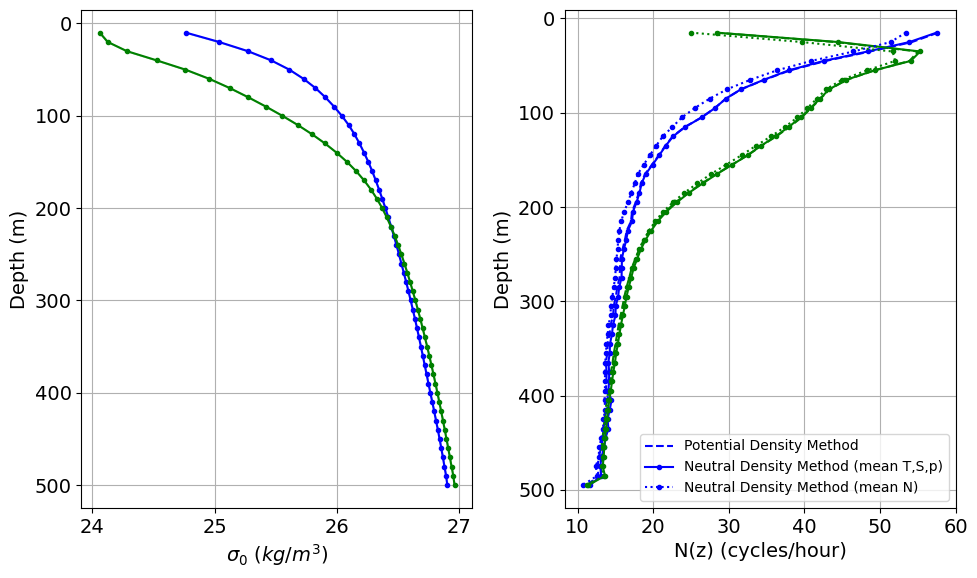

In [12]:
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

#--- Suplot #1 ---# 

# Plot Absolute salinity in on/off-shelf regions
axes[0].plot(meanSigma0_on,depth,'b.-')
axes[0].plot(meanSigma0_off,depth,'g.-')

# Plot standard error of the mean 
axes[0].fill_betweenx(depth,meanSigma0_on - stdmSigma0_on,meanSigma0_on + stdmSigma0_on,color="tab:blue",alpha=0.3)
axes[0].fill_betweenx(depth,meanSigma0_off - stdmSigma0_off,meanSigma0_off + stdmSigma0_off,color="tab:green",alpha=0.3)

# Set axis attributes
axes[0].set_xlabel(r"$\sigma_0$ ($kg/m^3$)")
axes[0].set_ylabel(r"Depth (m)")
axes[0].grid()

# Reverse the direction of the y-axis 
axes[0].invert_yaxis()

#--- Suplot #2 ---# 

# Plot bouyancy N(z) in units of cycles/hours in on/off-shelf regions
axes[1].plot(Nz_pdm_on*(60)*(60),depth_mid_pdm,'b--', label='Potential Density Method')
axes[1].plot(Nz_pdm_off*(60)*(60),depth_mid_pdm,'g--')
axes[1].plot(Nz_ndgm_on*(60)*(60),-1*depth_mid_ndgm,'b.-', label='Neutral Density Method (mean T,S,p)')
axes[1].plot(Nz_ndgm_off*(60)*(60),-1*depth_mid_ndgm,'g.-')
axes[1].plot(meanNz_on_hr,depth_mid,'b.:', label='Neutral Density Method (mean N)')
axes[1].plot(meanNz_off_hr,depth_mid,'g.:')

# Set axis attributes
axes[1].set_xlabel(r"N(z) (cycles/hour)")
axes[1].set_ylabel(r"Depth (m)")
axes[1].grid()
axes[1].legend(loc='lower right',fontsize=10)

# Reverse the direction of the y-axis 
axes[1].invert_yaxis()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/mean_Nz_profiles_'  + years_d[0] + '_to_' + years_d[-1] + '_' + season, bbox_inches = 'tight', dpi=300)

We decided **NOT** to compute the $N(z)$ profiles from the mean temperature, salinity, and pressure profiles because of the nonlinearity in the equation of state. That is, the order of operations matters when decided to compute the $N(z)$ profiles for each temperature, salinity, and pressure profile we had instead of computing it from the mean profile of all these quantities. We choose the latter. 

In addition, I decided to compute average the $N(z)$ profiles in each region instead of averaging the $N^2(z)$ profiles and then computing $N(z)$ profile. This is for the same reason as before, the $\sqrt{N^2(z)}$ is a nonlinear operation, so the order of operations matters. 

In [13]:
# Compute the bouyancy frequency from the mean N^2 profile and propagate error
meanNz_on_n = np.sqrt(meanNsquared_on)
meanNz_trans_n = np.sqrt(meanNsquared_trans)
meanNz_off_n = np.sqrt(meanNsquared_off)
stdmNz_off_n = (1/2) * ((meanNsquared_off)**(-1/2)) * stdmNsquared_off

Extend the $N(z)$ profile down to mean water depth of the on/transition/off-shelf region 

In [14]:
# Find the depth interval for the N(z) profile 
dz = np.unique(np.diff(depth_mid))

# Set the extrapolated depth bins for each region
depth_ext_on = np.arange(depth_mid[-1],-1*meanH_on,dz)
depth_ext_trans = np.arange(depth_mid[-1],-1*meanH_trans,dz)
depth_ext_off = np.arange(depth_mid[-1],-1*meanH_off,dz)

# Append depth values down to the sea floor for each region
dz = np.unique(np.diff(depth_mid))
depth_mid_on = np.append(depth_mid,depth_ext_on)
depth_mid_trans = np.append(depth_mid,depth_ext_trans)
depth_mid_off = np.append(depth_mid,depth_ext_off)

# Append a constant value (the last value in the profile) to the end of the N(z) profile in each region 
meanNz_on_ext =  np.append(meanNz_on,meanNz_on[-1]*np.ones(np.shape(depth_ext_on)))
meanNz_trans_ext =  np.append(meanNz_trans,meanNz_trans[-1]*np.ones(np.shape(depth_ext_trans)))
meanNz_off_ext =  np.append(meanNz_off,meanNz_off[-1]*np.ones(np.shape(depth_ext_off)))

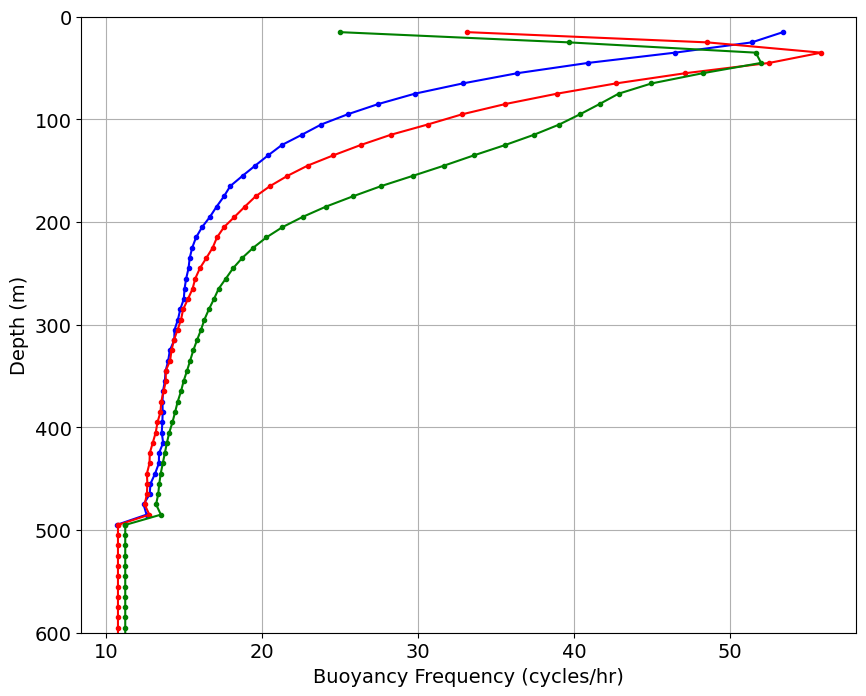

In [15]:
# Set plotting parameters
fontsize = 14
plt.rcParams.update({'font.size': fontsize}) 
plt.rcParams['text.usetex'] = False

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot buoyancy frequency in on/off-shelf regions
axes.plot(meanNz_on_ext*(3600),depth_mid_on,'b.-')
axes.plot(meanNz_trans_ext*(3600),depth_mid_trans,'r.-')
axes.plot(meanNz_off_ext*(3600),depth_mid_off,'g.-')

# Set axis attributes
axes.set_xlabel(r"Buoyancy Frequency (cycles/hr)")
axes.set_ylabel(r"Depth (m)")
axes.grid()
axes.set_ylim(0,600)

# Reverse the direction of the y-axis 
axes.invert_yaxis()

plt.show()